# 4 - Empirical Confirmation

This notebook is an implementation of the results described in the 4th section of the paper, which provides a real-world example of the deteriorating SNR values in the inference network of a VAE trained by an IWAE loss function.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..')) # include top level package in python path

In [2]:
import torch
from comparison.examples.vae_toy import VAE_Toy
from comparison.loss import ELBO_loss, IWAE_loss
from comparison.metric import sample_grads
from tqdm.notebook import tqdm

In [3]:
# Change device as needed. 
# CPU is supported on all machines, CUDA for specific GPUs.

# device = 'cpu'
device = 'cuda'

In [4]:
def cache_to_file(filename, f):
    filepath = os.path.join("toy", filename)
    try:
        return torch.load(filepath)
    except FileNotFoundError:
        data = f()
        torch.save(data, filepath)
        return data
    
def defer(f):
    def with_args(*args, **kargs):
        def deferred():
            return f(*args, **kargs)
        return deferred
    return with_args

Consider a family of generative models with $\mathbb{R}^D$–valued latent variables $z$ and observed variables $x$:

$$
\mathbf{z} \sim \mathcal{N}(\mathbf{z};\mu,I)\\ 
\mathbf{x \mid z} \sim \mathcal{N}(\mathbf{x} ; \mathbf{z}, I)
$$

which is parameterized by $\theta := \mu$. Let the inference network be parameterized by $\phi := (A,\mathbf{b})$, $A \in \mathbb{R}^{D\times D}, \mathbf{b} \in \mathbb{R}^D$ where 

$$q_\phi(\mathbf{z \mid x}) = \mathcal{N}(\mathbf{z} ; A\mathbf{x + b}, \frac{2}{3}I)$$

In [5]:
D = 20
model = VAE_Toy(D).to(device)

Given a dataset $(\mathbf{x}^{(n)})^N_{n=1}$, we can analytically calculate the optimum of our target $\mathcal{J}(\theta, \phi)$, giving $\theta^* := \mu^* = \frac{1}{N}\sum^N_{n=1}\mathbf{x}^{(n)}$, and $\phi^* := (A^*, \mathbf{b}^*)$, where $A^* = \frac{I}{2}$ and $\mathbf{b}^* = \frac{\mu^*}{2}$.

In [6]:
def opt_params(xs: torch.Tensor):
    D = xs.size(dim=1)
    mu_star = xs.mean(dim=0)
    b_star = mu_star / 2
    a_star = torch.eye(D).to(xs.device) / 2
    return mu_star, (a_star, b_star)

To conduct our investigation, we randomly generated a synthetic dataset from the model with $D=20$ dimensions, $N=1024$ data points, and a true model parameter value $\mu_\text{true}$ that was itself randomly generated from a unit Gaussian, i.e. $\mu_\text{true} \sim \mathcal{N}(\mu_\text{true};0, I)$. 

(Reproduction note: The original paper did not specify a standard deviation of the test dataset. In practice, we observed that a large variance of the test dataset overpowered the effects of any theoretical results on the gradient estimator of the generative network, so we picked a small value of $0.01$ to best display the results described by the paper)

In [7]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class DistDataset(Dataset):
    def __init__(self, dist, N, device=device):
        self.samples = cache_to_file(
            "ds-samples-0.dat",
            lambda: dist.sample(torch.Size([N])).to(device)
        )

    def __len__(self):
        return self.samples.size(dim=0)

    def __getitem__(self, idx):
        return self.samples[idx]
    
mu_true = torch.distributions.normal.Normal(
    torch.zeros(D), 
    torch.ones(D)
).sample()

dataset = DistDataset(
    torch.distributions.normal.Normal(
        mu_true, 
        torch.ones(20) * 0.01
    ), 
    N=1024
)

sampler = RandomSampler(dataset, replacement=True, num_samples=100_000)
loader = DataLoader(dataset, batch_size=128, sampler=sampler)

We then considered the gradient at a random point in the parameter space close to the optimum. Namely each dimension of each parameter was randomly offset from its optimum value using a zero-mean Gaussian with standard deviation $0.01$.

In [8]:
def off_opt_params(xs: torch.Tensor):
    def sample_err(shape: torch.Size):
        return cache_to_file(
            "sample-err-0.dat",
            lambda: torch.distributions.normal.Normal(
                torch.zeros(shape), 
                torch.ones(shape) * 0.01
            ).sample().to(xs.device)
        )
    mu_star, (a_star, b_star) = opt_params(xs)
    mu = mu_star + sample_err(mu_star.shape)
    a = a_star + sample_err(a_star.shape)
    b = b_star + sample_err(b_star.shape)
    return mu, (a, b)

In [9]:
mu, (a, b) = off_opt_params(dataset.samples)

model.mu.data = mu
model.inf_layer.weight.data = a
model.inf_layer.bias.data = b

We then calculated empirical estimates of the ELBO gradients for IWAE, where $M = 1$ is held fixed and we increase $K$, and for VAE, where $K=1$ is held fixed and we increase $M$. In all cases we calculated $10^4$ such estimates and used these samples to provide empirical estimates for, amongst other things, the mean and standard deviation of the estimator, and thereby an empirical estimate for the SNR.

In [10]:
def generate_grads(Ts, loss_fn, loader, encoder):
    
    all_grads = []

    for idx, T in enumerate(Ts):
        
        desc = (
            "Sampling Gradients for %s network with %s loss, %s = %s (%s / %s)"
            % (
                "inference" if encoder else "generator",
                "IWAE" if loss_fn == IWAE_loss else "VAE",
                "K" if loss_fn == IWAE_loss else "M",
                T.item(),
                idx + 1,
                len(Ts)
            )
        )
        
        grad_tuple = sample_grads(
            model, 
            tqdm(loader, desc=desc, leave=False), 
            tuple(model.encode_params() if encoder else model.decode_params()), 
            M=1 if loss_fn == IWAE_loss else T, 
            K=T if loss_fn == IWAE_loss else 1, 
            loss_fn=loss_fn,
            reshape=True
        )

        all_grads.append(grad_tuple)

    return torch.cat([g.unsqueeze(0) for g in all_grads], dim=0)
    

In [11]:
Ts = (10 ** torch.linspace(0, 3, 127)).int().unique_consecutive()

vae_enc_grads = cache_to_file(
    "vae-enc-grads-0.dat", 
    defer(generate_grads)(Ts, ELBO_loss, loader, encoder=True)
)
vae_dec_grads = cache_to_file(
    "vae-dec-grads-0.dat", 
    defer(generate_grads)(Ts, ELBO_loss, loader, encoder=False)
)
iwae_enc_grads = cache_to_file(
    "iwae-enc-grads-0.dat", 
    defer(generate_grads)(Ts, IWAE_loss, loader, encoder=True)
)
iwae_dec_grads = cache_to_file(
    "iwae-dec-grads-0.dat", 
    defer(generate_grads)(Ts, IWAE_loss, loader, encoder=False)
)

def is_iwae(grads):
    return grads.equal(iwae_enc_grads) or grads.equal(iwae_dec_grads)
def is_enc(grads):
    return grads.equal(vae_enc_grads) or grads.equal(iwae_enc_grads)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from comparison.plot import plot_density, plot_smoothed

hist_data = [
    (1, cm.viridis(1.0), 0.4),
    (3, cm.viridis(0.75), 0.4),
    (10, cm.viridis(0.5), 0.4),
    (100, cm.viridis(0.25), 0.4),
    (1000, cm.viridis(0.0), 0.4),
]

def plot_gradient_estimation(grads, ax, plot_best=True):
    lines = []

    loss_str = "IWAE" if is_iwae(grads) else "VAE"
    label_var = "K" if is_iwae(grads) else "M"
    parameter = "inference" if is_enc(grads) else "generative"
    
    snrs = torch.abs(grads.mean(dim=1) / grads.std(dim=1))
    best_final_snr = snrs[-1,:].argmax()
    
    peak = 1.5
    mean = None
    
    for idx in range(len(hist_data)):
        T, color, alpha = hist_data[idx]
        
        T_idxs = (Ts==T).nonzero().flatten()
        if len(T_idxs) == 0:
            continue
        T_grads = grads[T_idxs[0],:,best_final_snr if plot_best else -1]
        
        if T == 100:
            peak = 0.2 / T_grads.std().item()
        if T == 1000:
            mean = T_grads.mean().item()
        
        plot_density(
            T_grads.cpu(), 
            sigma=.005, color=color, alpha=alpha, ax=ax
        )
        lines.append(mpatches.Patch(color=color, label='%s = %s' % (label_var, T)))

        
    mean_line = ax.vlines(mean, 0, peak, color=cm.viridis(1.0), linestyles='dotted')
    mean_legend = ax.legend(handles=[
        Line2D(
            [0], [0], 
            color=cm.viridis(1.0), 
            label='Mean of %s = 1000' % label_var, 
            linestyle='dotted'
        )
    ], loc='upper left', facecolor=cm.viridis(0.0), edgecolor="black", framealpha=0.5)
    for text in mean_legend.get_texts():
        text.set_color("white")
    ax.legend(handles=lines)
    ax.add_artist(mean_legend)
    
    ax.set_xlabel("Δ(M,K)")
    ax.set_ylabel("p(Δ(M,K))")
    ax.set_title(
        "Distribution of gradient estimations of %s parameter with %s loss." 
        % (parameter, loss_str)
    )
    ax.set_ylim(0, peak)

We start by examining the qualitative behaviour of the different gradient estimators as $K$ increases as shown in Figure 1. 

This shows histograms of the IWAE gradient estimators for a single parameter of the inference network (left) and generative network (right).

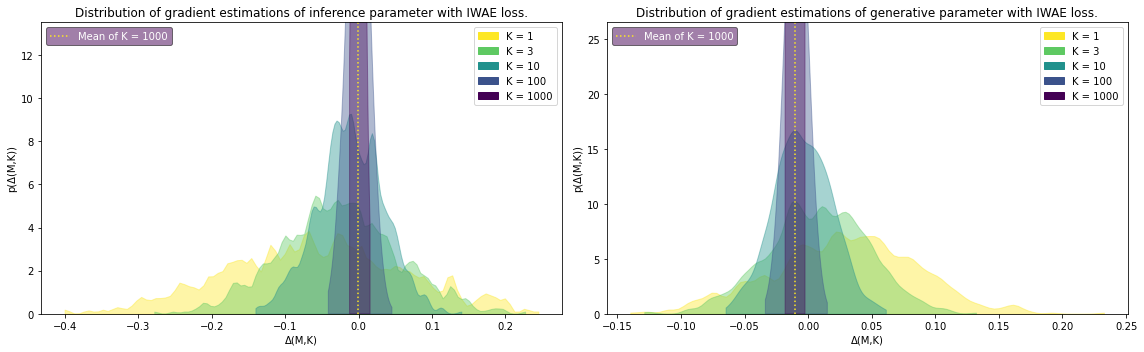

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(16)
plot_gradient_estimation(iwae_enc_grads, ax1, plot_best=False)
plot_gradient_estimation(iwae_dec_grads, ax2)
fig.tight_layout()

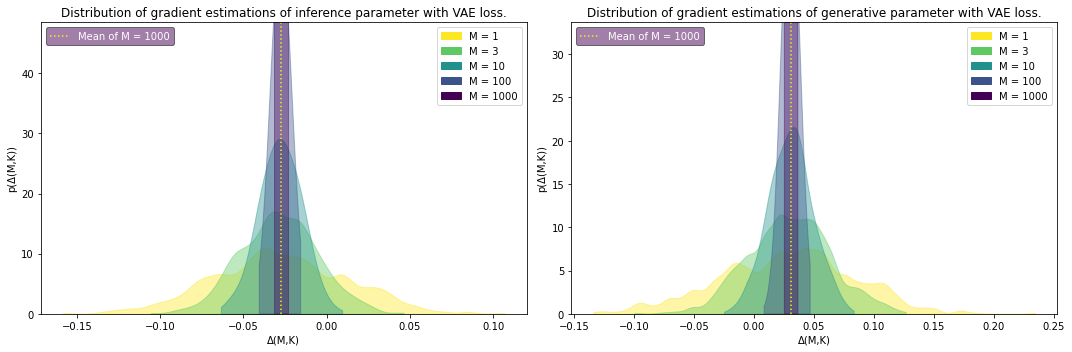

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
plot_gradient_estimation(vae_enc_grads, ax1)
plot_gradient_estimation(vae_dec_grads, ax2)
fig.tight_layout()

#### Signal-to-Noise Ratio

In [26]:
def plot_snr(vae_grads, iwae_grads, ax):
    
    vae_snrs = torch.abs(vae_grads.mean(dim=1) / vae_grads.std(dim=1))
    vae_mean_snr = vae_snrs.log().mean(dim=1).exp()
    
    iwae_snrs = torch.abs(iwae_grads.mean(dim=1) / iwae_grads.std(dim=1))
    iwae_mean_snr = iwae_snrs.log().mean(dim=1).exp()

    network_str = "inference" if is_enc(vae_grads) else "generative" 
    
    ax.plot(Ts.cpu(), vae_snrs.cpu(), color="lightcoral", alpha=20 / (vae_snrs.size(dim=1) ** 1.45))
    ax.plot(Ts.cpu(), iwae_snrs.cpu(), color="skyblue", alpha=20 / (iwae_snrs.size(dim=1) ** 1.45))
    ax.plot(Ts.cpu(), vae_mean_snr.cpu(), color="maroon", alpha=1.0)
    ax.plot(Ts.cpu(), iwae_mean_snr.cpu(), color="midnightblue", alpha=1.0)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, 1000)
    ax.set_ylim(10**-3, None)
    ax.set_xlabel("KM")
    ax.set_ylabel("SNR")
    ax.set_title("Convergence of SNR for %s network" % network_str)
    ax.legend(handles=[
        mpatches.Patch(color="lightcoral", label='VAE (K = 1)'),
        mpatches.Patch(color="skyblue", label='IWAE (M = 1)')
    ])

To provide a more rigorous analysis, we next directly examine the convergence of the SNR. Figure 2 shows the converge of the estimators with increasing $M$ and $K$. The observed rates for the inference network (left) correspond to our theoretical results, with the suggested rates observed all the way back to $K = M = 1$. As expected, we see that as $M$ increases, so does the SNR. But as $K$ increases, the SNR reduces.

In the convergence network (right), we see that the theoretical convergence for SNR is again observed exactly for variations in $M$, but a more unusual behaviour is seen for variations in $K$, where the SNR initially decreases before starting to increase again for large enough $K$, eventually exhibiting behaviour consistent with the theoretical result for large enough $K$.

(SNR was formally defined in Section 3. To reiterate, the definition is:

$$\text{SNR}_{M,K}(\theta) = 
\left| 
\frac{
\mathbb{E}[\Delta_{M,K}(\theta)]
}{
\sigma[\Delta_{M,K}(\theta)]
} 
\right|
$$

where $\sigma$ denotes the standard deviation of the random variable, and $\Delta_{M,K}$ denotes a stochastic gradient estimate for loss with fixed hyperparameters $M,K$ given a randomly sampled data point from the observed distribution, and $\theta$ here is an arbitrary model parameter.)

(Reproduction note: Lighter lines represent individual dimensions of the network parameteres, dark blue line represents the geometric mean of SNR over all dimensions.)

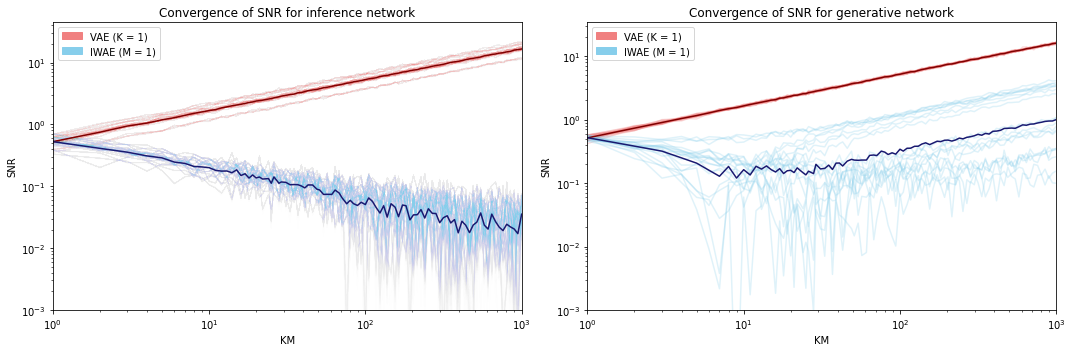

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
plot_snr(vae_enc_grads, iwae_enc_grads, ax1)
plot_snr(vae_dec_grads, iwae_dec_grads, ax2)
fig.tight_layout()

#### 4.1 Directional Signal-to-Noise Ratio

In [17]:
def norm_over(xs: torch.Tensor, *args, **kargs) -> torch.Tensor:
    return torch.sqrt((xs ** 2).sum(*args, **kargs))

def dsnr(u, grads):
    grads_pll = (u.unsqueeze(1) * grads).sum(dim=2).unsqueeze(dim=-1) * u.unsqueeze(1)
    grads_perp = grads - grads_pll
    dsnrs = norm_over(grads_pll, dim=-1) / norm_over(grads_perp, dim=-1)
    return dsnrs.mean(dim=1)

def plot_dsnr(vae_grads, iwae_grads, ax, use_k1000=False):
    
    enc = is_enc(vae_grads)
    iwae = is_iwae(vae_grads)
    
    network_str = "inference" if enc else "generative" 
    k1000_str = " against E[Δ(1,1000)]" if use_k1000 else ""
    
    vae_grads = vae_grads[:,:,-20:] if enc else vae_grads
    iwae_grads = iwae_grads[:,:,-20:] if enc else iwae_grads
    rand_grads = torch.distributions.normal.Normal(
        torch.tensor(0.),
        torch.tensor(1.)
    ).sample(vae_grads.shape).to(vae_grads.device)
    
    if use_k1000:
        exp = iwae_grads[-1].mean(dim=0)
        vae_u = (exp / norm_over(exp, dim=0).unsqueeze(-1)).unsqueeze(0)
        iwae_u = vae_u
    else:
        vae_exp = vae_grads.mean(dim=1)
        vae_u = vae_exp / norm_over(vae_exp, dim=1).unsqueeze(-1)
        iwae_exp = iwae_grads.mean(dim=1)
        iwae_u = iwae_exp / norm_over(iwae_exp, dim=1).unsqueeze(-1)
        
    vae_dsnr = dsnr(vae_u, vae_grads)
    iwae_dsnr = dsnr(iwae_u, iwae_grads)
    rand_dsnr = dsnr(iwae_u, rand_grads)
    

    ax.plot(Ts.cpu(), vae_dsnr.cpu(), color="lightcoral")
    ax.plot(Ts.cpu(), iwae_dsnr.cpu(), color="skyblue")
    ax.plot(Ts.cpu(), rand_dsnr.cpu(), color="yellowgreen")
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, 1000)
    ax.set_xlabel("KM")
    ax.set_ylabel("DSNR")
    ax.set_title(
        "Convergence of DSNR%s for %s network" 
        % (k1000_str, network_str)
    )
    ax.legend(handles=[
        mpatches.Patch(color="lightcoral", label='VAE (K = 1)'),
        mpatches.Patch(color="skyblue", label='IWAE (M = 1)'),
        mpatches.Patch(color="yellowgreen", label='Random Vector')
    ])

As a reassurance that our chosen definition of the SNR is appropriate for the problem at hand and to examine the effect of multiple dimensions explicitly, we now also conside ran alternative definition of the SNR. We refer to this as the "direction" SNR (DSNR). At a high-level, we define the DSNR by splitting each gradient estiamte into two component vectors, one parallel to the true gradient and one perpendicular, then taking the expectation of ratio of their magnitudes. More precisely, we define 

$$u = \frac{\mathbb{E}[\Delta_{M,K}]}{\lVert\mathbb{E}[\Delta_{M,K}]\rVert_2}$$

as being the true normalized gradient direction and then the DSNR as 

$$\text{DSNR}_{M,K} = \mathbb{E}\left[\frac{\lVert\Delta_{||}\rVert_2}{\lVert\Delta_\bot\rVert_2}\right]$$

where $\Delta_{||}=(\Delta_{M,K}\cdot u)u$ and $\Delta_\bot = \Delta_{M,K} - \Delta_{||}$.

The DSNR thus provides a measure of the expected proportion of the gradient that will point in the true direction. For perfect estimates of the gradients, the DSNR $\rightarrow \infty$, but unlike the SNR, arbitrarily bad estimates do not have DSNR $= 0$ because even random vectors will have a component of their gradient in the true direction.

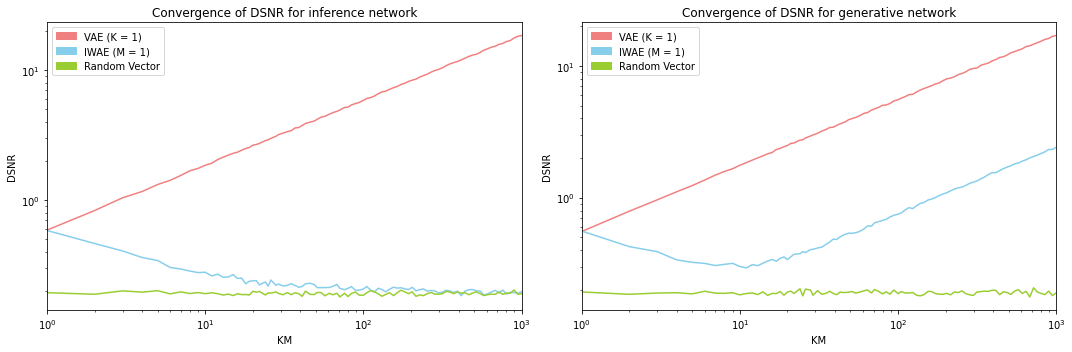

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
plot_dsnr(vae_enc_grads, iwae_enc_grads, ax1)
plot_dsnr(vae_dec_grads, iwae_dec_grads, ax2)
fig.tight_layout()

The true normalized gradient $u$ has been estimated empirically, noting that this varies with $K$. We see a similar qualitative behaviour to the SNR, with the gradients of IWAE for the inference network degrading to having the same directional accuracy as drawing a random vector. Interestingly, the DSNR seems to be following the same asymptotic convergence behaviour as the SNR for both networks in $M$, even though we have no theoretical result to suggest this should occur.

As our theoretical results suggest that the direction of the true gradients correspond to targeting an objective as $K$ increases, we now examine whether this or the changes in the SNR are the dominant effect. To this end, we repeat our calculations for the DSNR but take $u$ as the target direction of the gradient for $K = 1000$. This provides a measure of how varying $M$ and $K$ affects the quality of the gradient directions as biased estimators for $\mathbb{E}[\Delta_{1,1000}]/\lVert\mathbb{E}[\Delta_{1,1000}]\rVert_2$. Increasing $K$ is still detrimental for the inference network by this metric, even though it brings the expected gradient estimate closer to the target gradient. By contrast, increasing $K$ is now monotonically beneficial for the generative network. 

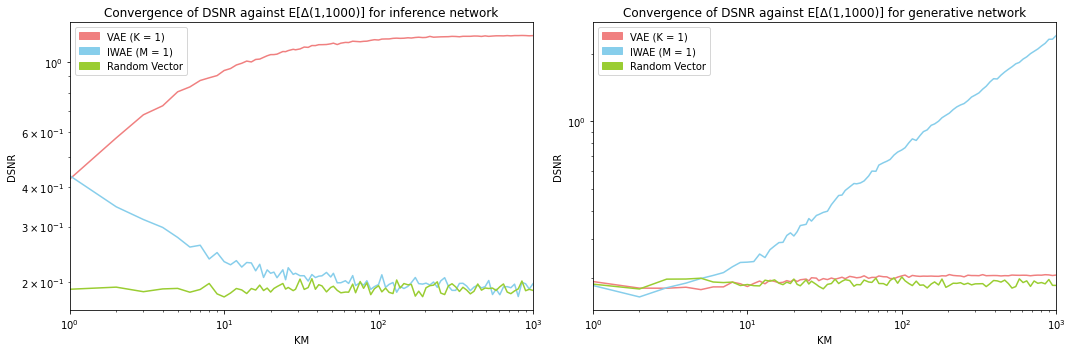

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
plot_dsnr(vae_enc_grads, iwae_enc_grads, ax1, use_k1000=True)
plot_dsnr(vae_dec_grads, iwae_dec_grads, ax2, use_k1000=True)
fig.tight_layout()